# Project

## Adience dataset

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import multiprocessing as mp
import pathos.multiprocessing as pmp # -pip install pathos (if not on machine)

print("TensorFlow version: " + tf.__version__)

TensorFlow version: 2.1.0


In [2]:
from sklearn.model_selection import KFold, train_test_split
import tensorflow.keras
from tqdm.auto import tqdm # - pip install tqdm (if not on machine)
from tensorflow.keras.utils import to_categorical

print('Loading Adience dataset...')

Loading Adience dataset...


In [3]:
from prep_enc_fld_1 import rgb_data_train, rgb_data_test, age_enc_train, age_enc_test, gender_train, gender_test, rgb_nolabel

TensorFlow version: 2.1.0
Loading Adience dataset...

----- USAGE INFO -------
make sure you have the folder name `processed data` and 5 files inside of it
The data has 5 folds, with fold_id from 0 to 4
This is first set of data for our DL models, it contains RGB of aligned images
all the function fetch_data_aligned(fold_id) to get the data from a fold_id
the data contains:
        age: age labels, 1D numpy array
        gender: gender labels, 1D numpy array
        RGB: 4D numpy array: 
            D1: picture id
            D2-D3: vertical and horizontal pixel id
            D4: channel
            value: RGB value     
For example:
    age, gender, RGB_data = fetch_data_aligned(0)
    this will return the data for fold 0
    

RGB DATA FOR CROPPED FACE ONLY:
    age, gender, RGB_data = fetch_data_cropped(fold_id)

NO LABEL DATA:
    no_label = fetch_nolabel_data()

TRAIN-VALID:
 [ 1454  1455  1456 ... 14537 14538 14539] 
TEST: [   0    1    2 ... 1451 1452 1453]
TRAIN-VALID:
 [    0

import collections
collections.Counter(age_enc_train)
#collections.Counter(age_enc_test)

np.isnan(gender_train).any()

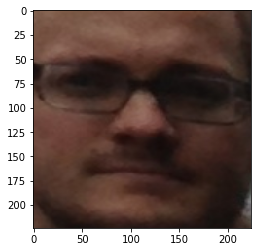

In [28]:
#rgb_data_train[2345,:,:,:].shape
plt.imshow(rgb_data_train[1500,:,:,:])

# Age detect

In [5]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 13164131808669080377
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6574135706
locality {
  bus_id: 1
  links {
  }
}
incarnation: 8046067347572731796
physical_device_desc: "device: 0, name: GeForce RTX 2080, pci bus id: 0000:01:00.0, compute capability: 7.5"
]


In [6]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPooling2D
from tensorflow.keras import regularizers, initializers
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.utils import to_categorical

age_cat_train = to_categorical(age_enc_train, num_classes=8)
age_cat_test = to_categorical(age_enc_test, num_classes=8)

epochs = 50
wd = 1e-3 #weight_decay
lr = 0.0001 #learning_rate
dr = lr / epochs #decay_rate

with tf.device('/GPU:0'): # Choose /CPU:0 or /GPU:0 depending on load...
    # model
    model = Sequential()
    model.add(Conv2D(96, kernel_size=11, strides=4, activation='relu', input_shape=(224,224,3), padding='valid', kernel_regularizer=regularizers.l2(wd))) # kernel_regularizer=regularizers.l1_l2(l1=wd, l2=wd) for both l1 and l2
    model.add(MaxPooling2D(pool_size=3, strides=2))
    model.add(Conv2D(256, kernel_size=5, strides=1, padding='same', activation='relu', kernel_regularizer=regularizers.l2(wd)))
    model.add(MaxPooling2D(pool_size=3, strides=2))
    model.add(Conv2D(384, kernel_size=3, strides=1,padding='same',  activation='relu', kernel_regularizer=regularizers.l2(wd)))
    model.add(Conv2D(384, kernel_size=3, strides=1,padding='same',  activation='relu', kernel_regularizer=regularizers.l2(wd)))
    model.add(Conv2D(256, kernel_size=3, strides=1,padding='same',  activation='relu', kernel_regularizer=regularizers.l2(wd)))
    model.add(MaxPooling2D(pool_size=3, strides=2))
    model.add(Flatten())
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(8, activation='softmax'))
    #callbacks
    reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=5, verbose=0)
    early_stop = EarlyStopping(monitor='accuracy', min_delta=0.0001, patience=10, verbose=0)
    #train
    custom_optm = tf.keras.optimizers.RMSprop(learning_rate=lr)
    model.compile(loss='categorical_crossentropy', optimizer=custom_optm, metrics=['accuracy'])
    datagen = ImageDataGenerator(featurewise_center=False, featurewise_std_normalization=False, rotation_range=0, width_shift_range=0.0, height_shift_range=0.0, horizontal_flip=False)
    datagen.fit(rgb_data_train)
    history = model.fit(datagen.flow(rgb_data_train, age_cat_train, batch_size=256), steps_per_epoch=len(rgb_data_train) / 256, epochs=epochs, callbacks=[reduce_lr], validation_data=(rgb_data_test, age_cat_test))
    scores = model.evaluate(rgb_data_test, age_cat_test, verbose=1)
    print('\nClassification loss on the test set:', scores[0])
    print('Classification accuracy on the test set:', scores[1]*100)

Using TensorFlow backend.


  ...
    to  
  ['...']
Train for 51.1171875 steps, validate on 1454 samples
Epoch 1/50
52/51 [==============================] - 25s 489ms/step - loss: 2.9313 - accuracy: 0.2974 - val_loss: 2.7597 - val_accuracy: 0.3012
Epoch 2/50
52/51 [==============================] - 8s 147ms/step - loss: 2.5837 - accuracy: 0.3070 - val_loss: 2.4657 - val_accuracy: 0.3542
Epoch 3/50
52/51 [==============================] - 8s 148ms/step - loss: 2.2962 - accuracy: 0.3464 - val_loss: 2.2610 - val_accuracy: 0.3370
Epoch 4/50
52/51 [==============================] - 8s 148ms/step - loss: 2.0798 - accuracy: 0.3951 - val_loss: 2.0382 - val_accuracy: 0.4264
Epoch 5/50
52/51 [==============================] - 8s 147ms/step - loss: 1.9477 - accuracy: 0.4230 - val_loss: 2.0161 - val_accuracy: 0.3762
Epoch 6/50
52/51 [==============================] - 8s 148ms/step - loss: 1.8426 - accuracy: 0.4454 - val_loss: 1.8865 - val_accuracy: 0.4333
Epoch 7/50
52/51 [==============================] - 8s 148ms/step - l

In [7]:
age_enc_test.shape

(1454, 1)

In [8]:
pred = model.predict(rgb_data_test, batch_size=32, verbose=1)

1454/1454 [==============================] - 1s 480us/sample


In [9]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


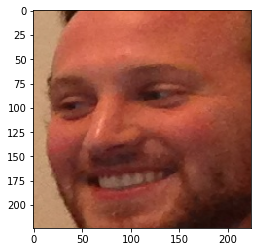

In [94]:
plt.imshow(rgb_data_test[1008,:,:,:])

In [96]:
age_cat_test[1008]

array([0., 0., 1., 0., 0., 0., 0., 0.], dtype=float32)

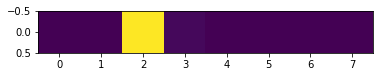

In [97]:
plt.imshow(pred[1008].reshape(1,8))

In [13]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 54, 54, 96)        34944     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 26, 26, 96)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 26, 26, 256)       614656    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 256)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 384)       885120    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 384)       1327488   
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 12, 12, 256)       8

In [14]:
nolabel_predict_age = model.predict(rgb_nolabel, verbose=1)
history2 = model.fit(rgb_nolabel, nolabel_predict_age)

2718/2718 [==============================] - 1s 325us/sample
Train on 2718 samples
2718/2718 [==============================] - 4s 1ms/sample - loss: 21.3293 - accuracy: 0.8955


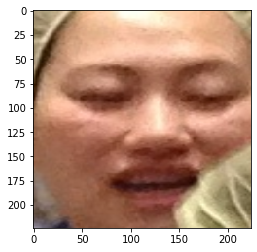

In [98]:
plt.imshow(rgb_nolabel[1708,:,:,:])

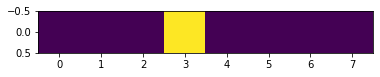

In [99]:
plt.imshow(nolabel_predict_age[1708].reshape(1,8))

plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

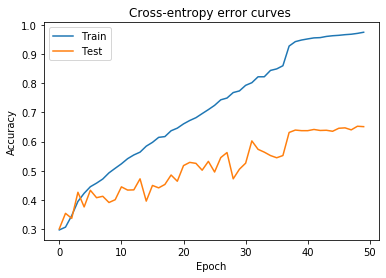

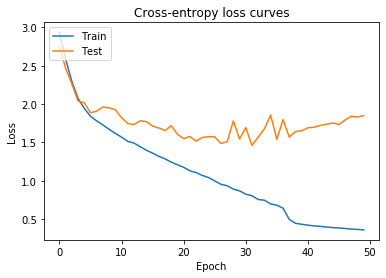

In [17]:
# Plot training & validation accuracy values for labeled data
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Cross-entropy error curves ')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Cross-entropy loss curves')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

Coefficients of first 5 filters of 1st Layer: 
 [[-0.01609509 -0.02343696  0.01248732  0.01030256  0.00815124 -0.01390306
  -0.01769213  0.00986485  0.01492804 -0.01746717  0.01081494]
 [-0.00257449  0.0138314  -0.00818516 -0.0170016  -0.00229822 -0.01593421
  -0.021895    0.00739161  0.01942425  0.0004689  -0.00795999]
 [ 0.00944744 -0.0166258  -0.02256219 -0.02228385  0.00414384  0.01158561
  -0.00932912  0.01772452  0.01192823  0.00610043 -0.00806945]
 [-0.00860797 -0.01087954 -0.02757306  0.01177166  0.00093115 -0.00523091
  -0.00417056  0.00541013 -0.00906321 -0.00297323 -0.00464759]
 [-0.01263182 -0.02081841 -0.00208105  0.0081167  -0.01938039 -0.01087379
  -0.01325251  0.01726528 -0.00869966 -0.016925    0.00014625]
 [-0.01237621 -0.02308919 -0.01208212  0.00700814  0.01381981 -0.02185856
   0.00471443 -0.00242555 -0.00213827 -0.00118161 -0.01576671]
 [-0.01343968  0.0110588  -0.02280758  0.00020055  0.01886508  0.00190208
   0.00399279 -0.00530197  0.01635908  0.01874401 -0.016

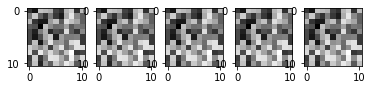

Coefficients of first 5 filters of 2nd Layer: 
 [[-0.01264898 -0.01871979  0.01818966 -0.00505    -0.01497827  0.0176647
   0.01571441  0.00061461 -0.00423653 -0.01338744  0.02239813]
 [ 0.02375473  0.00387925  0.01490683  0.01587649  0.01433314 -0.0152931
  -0.01681015 -0.0156898   0.00188337  0.00100459 -0.01308216]
 [ 0.0146021   0.01996965 -0.00562962  0.01909578 -0.00225288  0.00645607
   0.01986273 -0.00638782 -0.0104672   0.02069105 -0.01530757]
 [ 0.01371857  0.01868152 -0.01622099  0.00456105  0.00912704 -0.00895295
  -0.01024448  0.01893001  0.00851268 -0.00860607  0.0204846 ]
 [ 0.00827429  0.01694549 -0.01207944  0.01270265 -0.00524365 -0.01150047
   0.00869467  0.01925176  0.01834347 -0.00988987  0.01797037]
 [ 0.00124867  0.02219032 -0.0017036  -0.01784951 -0.0054289   0.00455554
  -0.02077662  0.00397113  0.00457515 -0.00199685 -0.00359482]
 [ 0.01927279  0.0215055   0.00102507  0.01586252  0.00467494  0.01177442
   0.01656533  0.01040134  0.01960323 -0.01869607 -0.01083

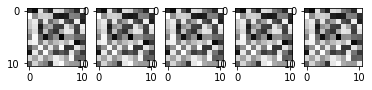

In [18]:
x1w=model.get_weights()[0][:,:,:,0][:,:,0]
print('Coefficients of first 5 filters of 1st Layer: \n', x1w)

for i in range(1,6):
    plt.subplot(1,5,i)
    plt.imshow(x1w[:,:],interpolation="nearest",cmap="gray")
plt.show()

x2w=model.get_weights()[0][:,:,:,2][:,:,0]
print('Coefficients of first 5 filters of 2nd Layer: \n', x2w)

for i in range(1,6):
    plt.subplot(1,5,i)
    plt.imshow(x2w[:,:],interpolation="nearest",cmap="gray")
plt.show()

In [19]:
for layer in model.layers:
    # check for convolutional layer
    if 'conv' not in layer.name:
        continue
    # get filter weights
    filters, biases = layer.get_weights()
    print(layer.name, filters.shape)

conv2d (11, 11, 3, 96)
conv2d_1 (5, 5, 96, 256)
conv2d_2 (3, 3, 256, 384)
conv2d_3 (3, 3, 384, 384)
conv2d_4 (3, 3, 384, 256)


In [20]:
y_pred = np.argmax(pred, axis=1)

In [21]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
confusion_matrix(age_enc_test,y_pred)

array([[ 66,   0,   1,   0,  12,   0,   0,   2],
       [  0,  58,  25,   5,   0,   0,   1,   7],
       [  0,  25, 330,  47,   3,   9,   6,  18],
       [  0,   9,  77, 119,   0,  13,   6,   6],
       [ 15,   4,   4,   2, 185,   0,   1,  27],
       [  0,   1,  28,  26,   0,  42,   7,   3],
       [  1,   0,   8,  13,   1,  17,  63,   5],
       [  2,  15,  31,   6,  17,   0,   1,  84]], dtype=int64)

In [22]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(age_enc_test,y_pred)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(age_enc_test,y_pred,average='weighted')
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(age_enc_test,y_pred,average='weighted')
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(age_enc_test,y_pred,average='weighted')
print('F1 score: %f' % f1)

Accuracy: 0.651307
Precision: 0.652961
Recall: 0.651307
F1 score: 0.649193


# Gender detect

In [62]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPooling2D
from tensorflow.keras import regularizers, initializers
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping
from keras.utils import to_categorical

gen_cat_train = to_categorical(gender_train, num_classes=2)
gen_cat_test = to_categorical(gender_test, num_classes=2)

epochs = 50
weight_decay = 1e-3

with tf.device('/GPU:0'): # Choose /CPU:0 or /GPU:0 depending on load...
    print('Gender prediction experiment running on GPU...')
    # model
    model2 = Sequential()  
    model2.add(Conv2D(96, kernel_size=11, strides=4, activation='relu', input_shape=(224,224,3), padding='valid', kernel_regularizer=regularizers.l2(weight_decay)))
    model2.add(MaxPooling2D(pool_size=3, strides=2))
    model2.add(Conv2D(256, kernel_size=5, strides=1, padding='same', activation='relu', kernel_regularizer=regularizers.l2(weight_decay)))
    model2.add(MaxPooling2D(pool_size=3, strides=2))
    model2.add(Conv2D(384, kernel_size=3, strides=1,padding='same',  activation='relu', kernel_regularizer=regularizers.l2(weight_decay)))
    model2.add(Conv2D(384, kernel_size=3, strides=1,padding='same',  activation='relu', kernel_regularizer=regularizers.l2(weight_decay)))
    model2.add(Conv2D(256, kernel_size=3, strides=1,padding='same',  activation='relu', kernel_regularizer=regularizers.l2(weight_decay)))
    model2.add(MaxPooling2D(pool_size=3, strides=2))
    model2.add(Flatten())
    model2.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model2.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.5))
    model2.add(Dense(2, activation='softmax'))
    #callbacks
    reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=5, verbose=0)
    early_stop = EarlyStopping(monitor='accuracy', min_delta=0.0001, patience=10, verbose=0)
    #train
    custom_optm = tf.keras.optimizers.RMSprop(learning_rate=0.0001)
    model2.compile(loss='binary_crossentropy', optimizer=custom_optm, metrics=['accuracy'])
    datagen = ImageDataGenerator(featurewise_center=False, featurewise_std_normalization=False, rotation_range=0, width_shift_range=0.0, height_shift_range=0.0, horizontal_flip=False)
    datagen.fit(rgb_data_train)
    history2 = model2.fit(datagen.flow(rgb_data_train, gen_cat_train, batch_size=256), steps_per_epoch=len(rgb_data_train) / 256, epochs=epochs, validation_data=(rgb_data_test, gen_cat_test))
    scores = model2.evaluate(rgb_data_test, gen_cat_test, verbose=1)
    print('\nClassification loss on the test set:', scores[0])
    print('Classification accuracy on the test set:', scores[1]*100)

Gender prediction experiment running on GPU...
  ...
    to  
  ['...']
Train for 51.1171875 steps, validate on 1454 samples
Epoch 1/50
52/51 [==============================] - 200s 4s/step - loss: 1.6190 - accuracy: 0.5481 - val_loss: 1.4459 - val_accuracy: 0.5791
Epoch 2/50
52/51 [==============================] - 8s 162ms/step - loss: 1.3308 - accuracy: 0.6035 - val_loss: 1.2263 - val_accuracy: 0.6142
Epoch 3/50
52/51 [==============================] - 8s 159ms/step - loss: 1.1419 - accuracy: 0.6296 - val_loss: 1.0680 - val_accuracy: 0.6458
Epoch 4/50
52/51 [==============================] - 8s 157ms/step - loss: 1.0305 - accuracy: 0.6607 - val_loss: 1.0335 - val_accuracy: 0.6410
Epoch 5/50
52/51 [==============================] - 8s 153ms/step - loss: 0.9562 - accuracy: 0.6844 - val_loss: 1.0184 - val_accuracy: 0.5942
Epoch 6/50
52/51 [==============================] - 8s 150ms/step - loss: 0.8875 - accuracy: 0.7137 - val_loss: 0.9593 - val_accuracy: 0.6100
Epoch 7/50
52/51 [======

In [63]:
print(history2.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


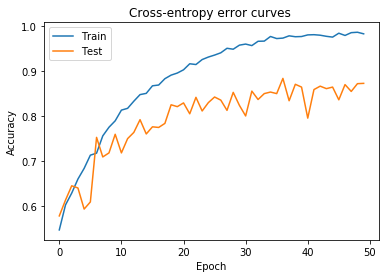

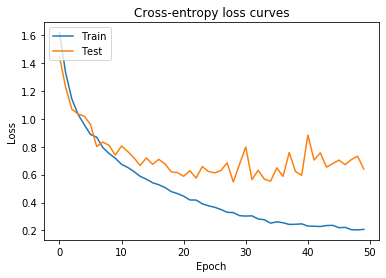

In [64]:
# Plot training & validation accuracy values
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('Cross-entropy error curves ')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Cross-entropy loss curves')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [65]:
for layer in model2.layers:
    # check for convolutional layer
    if 'conv' not in layer.name:
        continue
    # get filter weights
    filters, biases = layer.get_weights()
    print(layer.name, filters.shape)

conv2d_5 (11, 11, 3, 96)
conv2d_6 (5, 5, 96, 256)
conv2d_7 (3, 3, 256, 384)
conv2d_8 (3, 3, 384, 384)
conv2d_9 (3, 3, 384, 256)


In [66]:
print(model2.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 54, 54, 96)        34944     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 26, 26, 96)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 26, 26, 256)       614656    
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 12, 12, 256)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 12, 12, 384)       885120    
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 12, 12, 384)       1327488   
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 12, 12, 256)      

Coefficients of first 5 filters of 1st Layer: 
 [[ 0.00626766  0.00663831 -0.00094014 -0.0214351   0.00285418 -0.00315328
  -0.0178558   0.00346142 -0.00252643  0.01485869  0.00020111]
 [-0.00070816  0.00594484  0.01331996 -0.01205083 -0.00439552 -0.00334675
   0.0027147   0.00297099  0.00014295 -0.00726934  0.01950839]
 [ 0.01042473 -0.0173395   0.0034925  -0.01869698  0.01432683  0.0073725
   0.01895447  0.0157713   0.00634436 -0.00546378 -0.00874088]
 [ 0.00961876 -0.02284882 -0.00712836 -0.00936425 -0.00617713  0.0171083
  -0.00626785  0.00597778 -0.00405167  0.00801457  0.01951972]
 [-0.01408056 -0.00481182  0.01588148 -0.0050504   0.00071086  0.01568698
  -0.01451125  0.00514994  0.01036757  0.02368459 -0.00514578]
 [-0.01864937  0.00377728 -0.01551572 -0.01428709 -0.00523568  0.02039203
   0.00640408  0.01545253  0.0041523  -0.01296151  0.02398589]
 [-0.01543136  0.0097738   0.00018188 -0.00275423  0.00779424 -0.01786394
   0.0181207   0.01644771 -0.01384202 -0.00528857 -0.01183

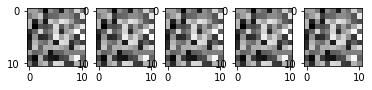

Coefficients of first 5 filters of 2nd Layer: 
 [[-1.07183317e-02  9.25790239e-03 -3.80264386e-03 -6.32705912e-03
   9.22502484e-03  6.80628745e-03  2.15826575e-02  4.42000339e-03
   8.45140591e-03  4.60682437e-03 -1.12639251e-03]
 [-1.77098531e-02  4.76440461e-03 -9.69648547e-03 -1.50630977e-02
  -1.79431885e-02 -1.91509735e-03 -1.22224875e-02  7.15056574e-03
   1.50830047e-02  1.65600851e-02  8.91753193e-03]
 [ 2.69802753e-03  4.10276494e-04 -1.36031944e-04  2.38123373e-03
  -4.99362871e-03  7.21946871e-03  3.76087939e-03  4.00963798e-03
   1.94487553e-02  3.30108311e-03  1.95967872e-02]
 [-1.84506495e-02  1.29506076e-02  6.38842175e-04 -2.12079822e-03
   1.22570535e-02 -1.68479432e-03 -3.57590895e-03  1.97815150e-02
  -5.47603797e-03 -7.33310310e-03  1.68256089e-02]
 [-2.15741917e-02 -7.35205179e-03  2.60588393e-04 -5.38825523e-03
  -6.34042721e-04  9.33118537e-03  1.01026027e-02  2.26170174e-03
   1.78967621e-02 -5.88064408e-03  5.01005072e-03]
 [ 8.15282762e-03 -2.03083735e-02 -7.

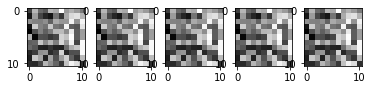

In [67]:
x1w=model2.get_weights()[0][:,:,:,0][:,:,0]
print('Coefficients of first 5 filters of 1st Layer: \n', x1w)

for i in range(1,6):
    plt.subplot(1,5,i)
    plt.imshow(x1w[:,:],interpolation="nearest",cmap="gray")
plt.show()

x2w=model2.get_weights()[0][:,:,:,3][:,:,0]
print('Coefficients of first 5 filters of 2nd Layer: \n', x2w)

for i in range(1,6):
    plt.subplot(1,5,i)
    plt.imshow(x2w[:,:],interpolation="nearest",cmap="gray")
plt.show()

In [68]:
pred2 = model2.predict(rgb_data_test, batch_size=32, verbose=1)

1454/1454 [==============================] - 1s 461us/sample


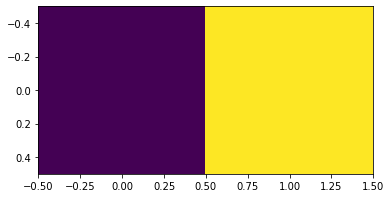

In [95]:
plt.imshow(pred2[1008].reshape(1,2))

In [70]:
nolabel_pred_gender = model2.predict(rgb_nolabel, verbose=1)
history2 = model.fit(rgb_nolabel, nolabel_predict_age)

2718/2718 [==============================] - 2s 614us/sample
Train on 2718 samples
2718/2718 [==============================] - 3s 1ms/sample - loss: nan - accuracy: 0.3440


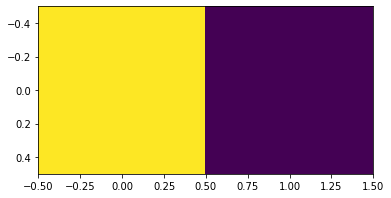

In [100]:
plt.imshow(nolabel_pred_gender[1708].reshape(1,2))

In [72]:
nolabel_pred_gender

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [0., 1.],
       [1., 0.],
       [0., 1.]], dtype=float32)

In [73]:
yg_pred = np.argmax(pred2, axis=1)

In [74]:
from sklearn.metrics import confusion_matrix
confusion_matrix(gender_test,yg_pred)

array([[718,  94],
       [ 91, 551]], dtype=int64)

In [75]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(gender_test,yg_pred)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(gender_test,yg_pred)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(gender_test,yg_pred)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(gender_test,yg_pred)
print('F1 score: %f' % f1)

Accuracy: 0.872765
Precision: 0.854264
Recall: 0.858255
F1 score: 0.856255
